# Sustracción de background usando un modelo encoder-decoder con módulos 3DCNN y ConvLSTM

### Autor: Anthony Benavides Arce

Importar librerias e inicializar

In [2]:
import numpy as np
import tensorflow as tf
import random as rn
import os, sys
import keras, glob
from keras import backend as K
import tensorflow as tf
from keras.preprocessing import image as kImage
from sklearn.utils import compute_class_weight
#from LSTM3DCnn_moduleDense import LSTMmodel
import matplotlib.pyplot as plt

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

maxShape = (240, 320, 3)
maxW = 320
maxH = 240

Num GPUs Available:  1


Funciones para plotear imágenes

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def imshow(img):
    plt.imshow(img/255, cmap='gray')
    plt.show()

def horizontal_imshow(images):
    plt.figure(figsize=(20,10))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image/255, cmap='gray')

# Lectura de los datos

Para la lectura de los datos empleo una clase llamada GenerateData, con la principal funcion llamada generate, en donde se lee el dataset de entrada y el groundtruth y se genera conjuntos de datos con 5 frames, el groundtruth respectivo.

In [4]:
class GenerateData:
    def __init__(self, maxW, maxH):
        self.maxW = maxW
        self.maxH = maxH

    def make_5d(self, data, n_look_back):

        k = 0
        n_samples = len(data)
        tmp = []
        data_5d = np.empty((n_samples-(n_look_back-1), n_look_back, data.shape[1], data.shape[2], data.shape[3]), dtype='float32')
        
        for i in range(0, n_samples):
            tmp = data[i:i+n_look_back]
            if tmp.shape[0] == n_look_back:
                # rotate the channels such that bring the current input as first channel
                for rotate_channel_id in range(0, n_look_back):
                    tmp[rotate_channel_id] = tmp[n_look_back-1-rotate_channel_id]
                tmp = tmp.reshape(1, n_look_back, data.shape[1], data.shape[2], data.shape[3])
                data_5d[k] = tmp
                tmp = [] # clear tmp
                k = k + 1
    
        return data_5d
    
    
    def generate(self, train_dir, dataset_dir, trainStart, trainEnd):
        framesBack= 5
        void_label = -1.
        
        # Given ground-truths, load training frames
        # ground-truths end with '*.png'
        # training frames end with '*.jpg'
        
        # given ground-truths, load inputs  
        Y_list = glob.glob(os.path.join(train_dir, '*.png'))
        X_list= glob.glob(os.path.join(dataset_dir,'*.jpg'))
        
        if len(Y_list)<=0 or len(X_list)<=0:
            raise ValueError('System cannot find the dataset path or ground-truth path. Please give the correct path.')
          
        if len(X_list)!=len(Y_list):
            raise ValueError('The number of X_list and Y_list must be equal.')   
            
        # X must be corresponded to Y
        X_list = sorted(X_list)
        Y_list = sorted(Y_list)
        
        #Solo quedarme con ls imagener comprendidas en el intervalo trainStart - trainEnd
        X_list = X_list[trainStart:trainEnd]
        Y_list = Y_list[trainStart:trainEnd]
        
        # load training data
        X = []
        Y = []
        #np.set_printoptions(threshold=sys.maxsize)
    
        for i in range(len(X_list)):
            x = kImage.load_img(X_list[i], target_size=(self.maxW, self.maxH))
            x = kImage.img_to_array(x)
            X.append(x)
         
        #for i in range(framesBack-1,len(Y_list)):
        for i in range(len(Y_list)):
            x = kImage.load_img(Y_list[i], grayscale = True, target_size=(self.maxW, self.maxH))
            x = kImage.img_to_array(x)
            shape = x.shape
            x/=255.0
            x = x.reshape(-1)
            idx = np.where(np.logical_and(x>0.25, x<0.8))[0] # find non-ROI
            if (len(idx)>0):
                x[idx] = void_label
            x = x.reshape(shape)
            x = np.floor(x)
            Y.append(x)
            
        X = np.asarray(X)
        Y = np.asarray(Y)
           
        
        X = self.make_5d(X, framesBack)
        print('Forma de entrada', X.shape)
        
        Y = self.make_5d(Y, framesBack)
        print('Forma de salida', Y.shape)
        
        # compute class weights
        cls_weight_list = []
        for i in range(Y.shape[0]):
            y = Y[i].reshape(-1)
            idx = np.where(y!=void_label)[0]
            if(len(idx)>0):
                y = y[idx]
            lb = np.unique(y) #  0., 1
            cls_weight = compute_class_weight('balanced', lb , y)
            class_0 = cls_weight[0]
            class_1 = cls_weight[1] if len(lb)>1 else 1.0
            
            cls_weight_dict = {0:class_0, 1: class_1}
            cls_weight_list.append(cls_weight_dict)
    
        cls_weight_list = np.asarray(cls_weight_list)
        
        return [X, Y, cls_weight_list]

# Modelo

In [5]:
import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv3D
from keras.layers import Dropout
from keras.layers import ConvLSTM2D
from keras.layers import Activation
from keras.layers import concatenate
from keras.layers import Conv3DTranspose
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Flatten
import tensorflow as tf

from keras import backend as K

def loss(y_true, y_pred):
    void_label = -1.
    y_pred = K.reshape(y_pred, [-1])
    y_true = K.reshape(y_true, [-1])
    idx = tf.where(tf.not_equal(y_true, tf.constant(void_label, dtype=tf.float32)))
    y_pred = tf.gather_nd(y_pred, idx) 
    y_true = tf.gather_nd(y_true, idx)
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

def fMeasure(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    TP = K.sum(y_pos * y_pred_pos)
    #TN = K.sum(y_neg * y_pred_neg)

    FP = K.sum(y_neg * y_pred_pos)
    FN = K.sum(y_pos * y_pred_neg)

    numerator = (2*TP)
    denominator = (2*TP)+FP+FN
    return numerator / (denominator + K.epsilon())
    
def PWC(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    TP = K.sum(y_pos * y_pred_pos)
    TN = K.sum(y_neg * y_pred_neg)


    FP = K.sum(y_neg * y_pred_pos)
    FN = K.sum(y_pos * y_pred_neg)

    numerator = 100*(FN+FP)
    denominator = (TP+FN+FP+TN)
    return numerator / (denominator + K.epsilon())

class LSTMmodel:

    def sendec_block1(input_tensor):
        x1 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 2, 2),
                       activation='relu',
                       padding='same', data_format='channels_last')(input_tensor)             
        x = Conv3DTranspose(filters=16, kernel_size=(2, 3, 3), strides=(1, 2, 2), 
            padding='same', data_format='channels_last')(x1) 
        x = concatenate([input_tensor, x], axis=-1) 
        x = BatchNormalization()(x)    
        x = Conv3D(filters=16, kernel_size=(1, 3, 3), strides=(1, 1, 1), 
            activation='relu', padding='same', data_format='channels_last')(x)

        return x1, x



    def _sEnDec_cnn_lstm(input_dim, dp):

        
        print('[Modelo] Creando sEnDec_cnn_lstm Model...\n')
        input_layer = Input(shape=input_dim, name='input_layer')    
        seq0 = Conv3D(filters=16, kernel_size=(1, 3, 3), strides=(1, 1, 1),
                       activation='relu',
                       padding='same', data_format='channels_last')(input_layer)    

        # - SEnDec block 1
        seq1, seq12 = LSTMmodel.sendec_block1(seq0)

        seq13 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 2, 2),
                       activation='relu',
                       padding='same', data_format='channels_last')(seq12)  
        
        # - SEnDec block 2
        seq2, seq22 = LSTMmodel.sendec_block1(seq13)                

        seq22 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 2, 2),
                       activation='relu',
                       padding='same', data_format='channels_last')(seq22)
        
        # - SEnDec block 3
        seq30, seq32 = LSTMmodel.sendec_block1(seq22)

        seq3 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 2, 2),
                       activation='relu',
                       padding='same', data_format='channels_last')(seq32) 
        seq4 = ConvLSTM2D(filters=16, kernel_size=(3, 3), strides=(2, 2),
                activation='relu', padding='same', return_sequences=True)(seq3) 
        
        
        #-~~~~~~~~~~~~~~~~~~ Upsampling ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                 
        seq6 = Conv3DTranspose(filters=16, kernel_size=(2, 3, 3), 
                strides=(1, 2, 2), padding='same', data_format='channels_last')(seq4)     
        seq6 = concatenate([seq6, seq3], axis=-1) 
        
        seq6 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 1, 1), padding='same', data_format='channels_last')(seq6)
        seq6 = BatchNormalization()(seq6)
        seq6 = Activation('relu')(seq6)
        seq6 = concatenate([seq6, seq30], axis=-1)       
        
        seq7 = Conv3DTranspose(filters=16, kernel_size=(2, 3, 3), 
                strides=(1, 2, 2), padding='same', data_format='channels_last')(seq6) 
        seq7 = concatenate([seq7, seq22], axis=-1) 
                      
        seq7 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 1, 1), padding='same', data_format='channels_last')(seq7)
        seq7 = BatchNormalization()(seq7)
        seq7 = Activation('relu')(seq7)
        seq7 = concatenate([seq7, seq2], axis=-1) 
        
        seq8 = Conv3DTranspose(filters=16, kernel_size=(2, 3, 3), 
                strides=(1, 2, 2), padding='same', data_format='channels_last')(seq7)  
        seq8 = concatenate([seq8, seq13], axis=-1) 
        seq8 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 1, 1), padding='same', data_format='channels_last')(seq8)
        
        seq8 = BatchNormalization()(seq8)
        seq8 = Activation('relu')(seq8)
        seq8 = concatenate([seq8, seq1], axis=-1) 
        
        seq9 = Conv3DTranspose(filters=16, kernel_size=(2, 3, 3), 
                strides=(1, 2, 2), padding='same', data_format='channels_last')(seq8) 
        seq9 = concatenate([seq9, seq0], axis=-1) 
        seq9 = Conv3D(filters=32, kernel_size=(1, 3, 3), strides=(1, 1, 1), padding='same', data_format='channels_last')(seq9)
        
        seq9 = BatchNormalization()(seq9)
        seq9 = Activation('relu')(seq9)
        

        seq91 = Dropout(dp)(seq9)

        output_layer = Conv3D(filters=1, kernel_size=(2, 3, 3), strides=(1, 1, 1),
                       activation='sigmoid',
                       padding='same', data_format='channels_last')(seq91)
        
       
        
        vision_model = Model(input_layer, outputs=output_layer)

        vision_model.compile(loss=loss, optimizer="adam", metrics=[fMeasure,PWC])
        
        print('[Modelo] Creación del modelo completada')
        
        return vision_model
    

In [6]:
shape_prueba = (5, 720, 576, 3)
model = LSTMmodel._sEnDec_cnn_lstm(shape_prueba, 0.2)
model.summary()

[Modelo] Creando sEnDec_cnn_lstm Model...

[Modelo] Creación del modelo completada
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 5, 720, 576, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 5, 720, 576,  448         input_layer[0][0]                
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 5, 360, 288,  4640        conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_transpose (Conv3DTranspo (None, 5, 720, 576,  9232        conv3d_1[0][0]                   
___________

# Entrenamiento

Setear hiperparámetros

In [7]:
#setear valores para el entrenamientos
max_epochs = 50
val_split = 0.2
batch_size = 1
dp = 0.2

# =============================================================================
trainStart = 0
trainEnd = 200

main_dir = 'C:/bs_dir'
output_dir = os.path.join(main_dir, 'TrainResults','50epochs200framesJupyter')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

generateData = GenerateData(maxW, maxH)

Función de entrenamiento

In [8]:
def train(category, scene):
   
    #seteando rutas de directorios
    train_dir = os.path.join(main_dir, 'CDnet2014_dataset', category, scene, 'groundtruth')
    dataset_dir = os.path.join(main_dir, 'CDnet2014_dataset', category, scene, 'input')
    mdl_path = os.path.join(output_dir, 'mdl_' + scene + '.h5')

    #llamar a la funcion de generacion de datos
    print ('Generando datos ->>> ' + category + ' / ' + scene)
    results = generateData.generate(train_dir, dataset_dir, trainStart, trainEnd)
    
    #instanciar modelo
    print ('Entrenando ->>> ' + category + ' / ' + scene)
    img_shape = results[0][0].shape # (height, width, channel)
    model = LSTMmodel._sEnDec_cnn_lstm(img_shape, dp)
    #model.summary()
    
    
    weight_saver = keras.callbacks.ModelCheckpoint(mdl_path, 
                                                   monitor='val_loss', 
                                                   verbose=0, 
                                                   save_best_only=True, 
                                                   save_weights_only=False, 
                                                   mode='auto', 
                                                   period=1)
    
    #entrenamiento
    result_history = model.fit(
                            results[0],
                            results[1], 
                            batch_size = batch_size,
                            steps_per_epoch = None,
                            validation_split=val_split,
                            epochs=max_epochs, verbose=1,
                            callbacks = [weight_saver]
                            #,class_weight=results[2]
                            )
    
    del model, results, weight_saver
    return result_history

Función principal para el entrenamiento

In [9]:
category = 'baseline'
scene  = 'highway'

history_highway = train(category, scene)   

Generando datos ->>> baseline / highway
C:/bs_dir\CDnet2014_dataset\baseline\highway\input


C:\Users\antbe\Anaconda\envs\deeplearning\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Forma de entrada (196, 5, 320, 240, 3)
Forma de salida (196, 5, 320, 240, 1)


C:\Users\antbe\Anaconda\envs\deeplearning\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Entrenando ->>> baseline / highway
[Modelo] Creando sEnDec_cnn_lstm Model...

[Modelo] Creación del modelo completada
Epoch 1/50
156/156 [==============================] - 98s 629ms/step - loss: 0.0265 - fMeasure: 0.4650 - PWC: 0.5162 - val_loss: 0.0957 - val_fMeasure: 0.6618 - val_PWC: 1.7635
Epoch 2/50
156/156 [==============================] - 96s 615ms/step - loss: 0.0015 - fMeasure: 0.7851 - PWC: 0.2123 - val_loss: 0.0182 - val_fMeasure: 0.8091 - val_PWC: 0.9299
Epoch 3/50
156/156 [==============================] - 96s 615ms/step - loss: 4.8771e-04 - fMeasure: 0.7993 - PWC: 0.1992 - val_loss: 0.0117 - val_fMeasure: 0.8530 - val_PWC: 0.7362
Epoch 4/50
156/156 [==============================] - 96s 613ms/step - loss: 2.4880e-04 - fMeasure: 0.7966 - PWC: 0.2036 - val_loss: 0.0119 - val_fMeasure: 0.8493 - val_PWC: 0.7726
Epoch 5/50
156/156 [==============================] - 96s 616ms/step - loss: 1.6129e-04 - fMeasure: 0.7984 - PWC: 0.2028 - val_loss: 0.0112 - val_fMeasure: 0.8545 - v

Epoch 45/50
156/156 [==============================] - 27s 170ms/step - loss: 2.0307e-06 - fMeasure: 0.7994 - PWC: 0.2024 - val_loss: 0.0109 - val_fMeasure: 0.8702 - val_PWC: 0.6721
Epoch 46/50
156/156 [==============================] - 27s 171ms/step - loss: 1.7750e-06 - fMeasure: 0.7987 - PWC: 0.2034 - val_loss: 0.0104 - val_fMeasure: 0.8677 - val_PWC: 0.6873
Epoch 47/50
156/156 [==============================] - 27s 170ms/step - loss: 1.6063e-06 - fMeasure: 0.7997 - PWC: 0.2027 - val_loss: 0.0129 - val_fMeasure: 0.8709 - val_PWC: 0.6660
Epoch 48/50
156/156 [==============================] - 27s 171ms/step - loss: 1.4852e-06 - fMeasure: 0.7999 - PWC: 0.2025 - val_loss: 0.0110 - val_fMeasure: 0.8689 - val_PWC: 0.6795
Epoch 49/50
156/156 [==============================] - 35s 227ms/step - loss: 1.7207e-06 - fMeasure: 0.7992 - PWC: 0.2034 - val_loss: 0.0111 - val_fMeasure: 0.8750 - val_PWC: 0.6429
Epoch 50/50
156/156 [==============================] - 27s 171ms/step - loss: 1.5769e-06 -

Plotear historial de entrenamiento

dict_keys(['loss', 'fMeasure', 'PWC', 'val_loss', 'val_fMeasure', 'val_PWC'])


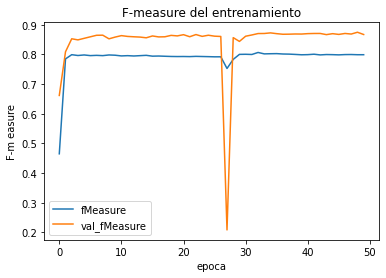

In [13]:
# list all data in history
print(history_highway.history.keys())

# plotear historial de fmeasure 
plt.plot(history_highway.history['fMeasure'])
plt.plot(history_highway.history['val_fMeasure'])
plt.title('F-measure del entrenamiento')
plt.ylabel('F-m easure')
plt.xlabel('epoca')
plt.legend(['fMeasure', 'val_fMeasure'])
plt.show()

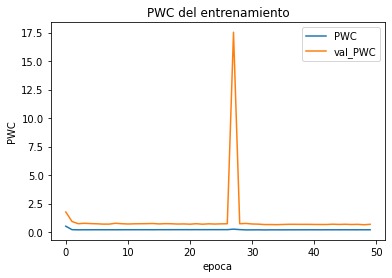

In [14]:
# plotear historial de PWC 
plt.plot(history_highway.history['PWC'])
plt.plot(history_highway.history['val_PWC'])
plt.title('PWC del entrenamiento')
plt.ylabel('PWC')
plt.xlabel('epoca')
plt.legend(['PWC', 'val_PWC'])
plt.show()

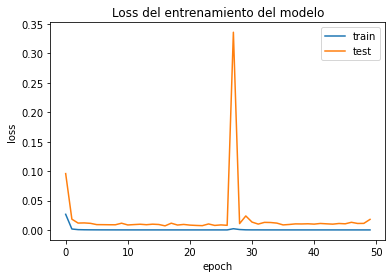

In [15]:
# summarize history for loss
plt.plot(history_highway.history['loss'])
plt.plot(history_highway.history['val_loss'])
plt.title('Loss del entrenamiento del modelo')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Prueba

Funcion para setear threshold

In [8]:
def threshold(img, thd):
    img[img >= thd] = 1
    img[img < thd] = 0
    return img

Funciones para calcular los score

In [9]:
def numeric_score(prediction, groundtruth):
    FP = np.float(np.sum((prediction == 1) & (groundtruth == 0)))
    FN = np.float(np.sum((prediction == 0) & (groundtruth == 1)))
    TP = np.float(np.sum((prediction == 1) & (groundtruth == 1)))
    TN = np.float(np.sum((prediction == 0) & (groundtruth == 0)))

    numDecimales = 3

    FMEASURE = round( 2*TP/(2*TP+FP+FN), numDecimales)
    PWC = round( 100*(FN+FP)/(TP+FN+FP+TN), numDecimales)
    
    return FP, FN, TP, TN, FMEASURE, PWC

Funcion encargada de recibir un listado de predicciones y groudtruths para calcular el score promedio

In [10]:
def average_numeric_score(prediction, groundtruth):
    total_fmeasure = 0
    total_PWC = 0
    for i in range(len(prediction)):
        predict = prediction[i][4]
        gt = groundtruth[i][4]        
        
        predict = threshold(predict, 0.75)

        FP, FN, TP, TN, FMEASURE, PWC = numeric_score(predict, gt)
        total_fmeasure += FMEASURE
        total_PWC  += PWC

    print('Fmeasure: ', total_fmeasure/len(prediction), ', PWC: ', total_PWC/len(prediction))

Funcion de testeo

In [10]:
category = 'baseline'
scene  = 'highway'

trainStart = 200
trainEnd = 220

#cargar modelo
print ('Cargando pesos del modelo ->>> ' + category + ' / ' + scene)
weightsDir = os.path.join(output_dir, 'mdl_' + scene + '.h5')
model = tf.keras.models.load_model(weightsDir, custom_objects={'loss': loss}, compile=False)
#model.summary()

#setear directorios
train_dir = os.path.join(main_dir, 'CDnet2014_dataset', category, scene, 'groundtruth')
dataset_dir = os.path.join(main_dir, 'CDnet2014_dataset', category, scene, 'input')

#generar datos
print ('Generando datos ->>> ' + category + ' / ' + scene)
testData = generateData.generate(train_dir, dataset_dir, trainStart, trainEnd)

#testear data con el modelo entrenado
print ('Testing frame->>> ' + category + ' / ' + scene + ' / ', trainStart, '->', trainEnd)
result = model.predict(testData[0], verbose = 1)

average_numeric_score(result, testData[1])

del testData

Cargando pesos del modelo ->>> baseline / highway
Generando datos ->>> baseline / highway
C:/bs_dir\CDnet2014_dataset\baseline\highway\input
Forma de entrada (16, 5, 320, 240, 3)
Forma de salida (16, 5, 320, 240, 1)


C:\Users\antbe\Anaconda\envs\deeplearning\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\antbe\Anaconda\envs\deeplearning\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Testing frame->>> baseline / highway /  200 -> 220
1/1 [==============================] - 0s 3ms/step
Fmeasure:  0.7393125 , PWC:  2.2213125


Funcion para testear un frame en especifico y mostrar resultados

In [24]:
def testSpecificFrame(weightsDir, category, scene, numImg):
    #cargar modelo
    model = tf.keras.models.load_model(weightsDir, custom_objects={'loss': 'binary_crossentropy'}, compile=False)
    
    #setear directorios
    train_dir = os.path.join(main_dir, 'CDnet2014_dataset', category, scene, 'groundtruth')
    dataset_dir = os.path.join(main_dir, 'CDnet2014_dataset', category, scene, 'input')
    
    #generar datos
    print ('Generando datos ->>> ' + category + ' / ' + scene)
    testData = generateData.generate(train_dir, dataset_dir, numImg, numImg+5)
    
    #testear data con el modelo entrenado
    print ('Testing frame->>> ' + category + ' / ' + scene + ' / ' + str(numImg))
    result = model.predict(testData[0],verbose = 1)

    
    input = testData[0][0][4]
    groundtruth = testData[1][0][4]
    prediction = threshold(result[0][4], 0.75)
    
    
    FP, FN, TP, TN, FMEASURE, PWC = numeric_score(prediction, testData[1][0][4])
    print('FMEASURE: ',FMEASURE , 'PWC: ', PWC)

    return input, groundtruth, prediction

# Resultados Cualitativos

Plotear frames para los resultados cualitativos

Generando datos ->>> baseline / highway
C:/bs_dir\CDnet2014_dataset\baseline\highway\input
Forma de entrada (1, 5, 320, 240, 3)
Forma de salida (1, 5, 320, 240, 1)
Testing frame->>> baseline / highway / 250
1/1 [==============================] - 0s 999us/step
FMEASURE:  0.963 PWC:  0.215


<ipython-input-23-dba73f212939>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, i + 1)


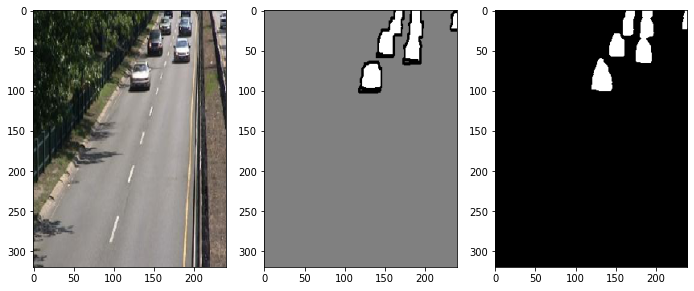

In [25]:
category = 'baseline'
scene  = 'highway'
numImg = 250
nameh5weights = os.path.join(output_dir,'mdl_highway.h5')
input, groundtruth, prediction = testSpecificFrame(nameh5weights, category, scene, numImg)
horizontal_imshow([input, groundtruth, prediction])

Generando datos ->>> baseline / highway
C:/bs_dir\CDnet2014_dataset\baseline\highway\input
Forma de entrada (1, 5, 320, 240, 3)
Forma de salida (1, 5, 320, 240, 1)
Testing frame->>> baseline / highway / 800
1/1 [==============================] - 0s 963us/step
FMEASURE:  0.954 PWC:  0.108


<ipython-input-23-dba73f212939>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, i + 1)


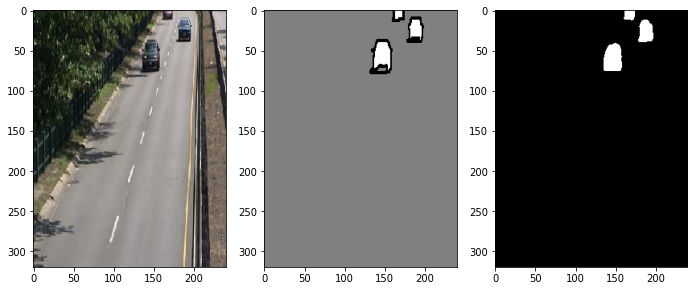

In [26]:
category = 'baseline'
scene  = 'highway'
numImg = 800
nameh5weights = os.path.join(output_dir,'mdl_highway.h5')
input, groundtruth, prediction = testSpecificFrame(nameh5weights, category, scene, numImg)
horizontal_imshow([input, groundtruth, prediction])

Generando datos ->>> baseline / highway
C:/bs_dir\CDnet2014_dataset\baseline\highway\input
Forma de entrada (1, 5, 320, 240, 3)
Forma de salida (1, 5, 320, 240, 1)
Testing frame->>> baseline / highway / 300
1/1 [==============================] - 0s 998us/step
FMEASURE:  0.849 PWC:  1.825


<ipython-input-23-dba73f212939>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, i + 1)


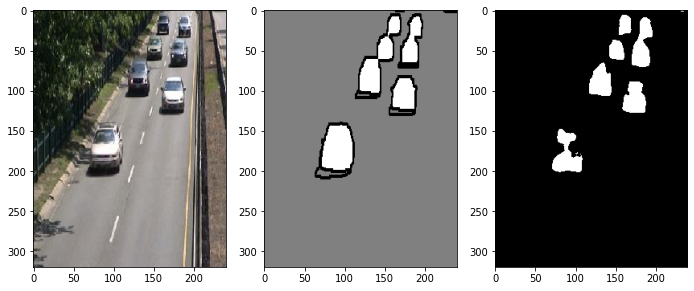

In [27]:
category = 'baseline'
scene  = 'highway'
numImg = 300
nameh5weights = os.path.join(output_dir,'mdl_highway.h5')
input, groundtruth, prediction = testSpecificFrame(nameh5weights, category, scene, numImg)
horizontal_imshow([input, groundtruth, prediction])